Welcome back! In our [last post](https://samsaara.github.io/posts/geospatial_intro_part_I/GIS.html), we took a look at the basics of GIS and how we can explore some of the datasets in QGIS with shapefiles, TIFF files to derive interesting insights around air quality. This post covers loading data from CSV files on disk and also directly from online using server connections.

# Load data from text files

For this use case, let's examine the latest satellite data where potential 🔥 events were detected in North American region. This could be a wildfire or controlled fire or anything else and may also occupy less than one pixel of the 🛰️ image depending on the resolution of that 🛰️ that's taking it. [NOAA](https://www.noaa.gov/)'s Hazard Mapping System (HMS) provide daily updated data for fire & smoke detected. Let's [download the latest data](https://www.ospo.noaa.gov/Products/land/hms.html#data). There are multiple data formats available but since we have seen shapefile in the last post, let's try `text` file now.

::: {#fig- }
![](images/hms.jpg)

HMS data download
:::

Let's read a few lines from the file:

In [2]:
import pandas as pd

In [14]:
df = pd.read_csv('data/hms_fire20230306.txt')

In [18]:
df.shape

(24485, 8)

In [19]:
df.sample(10)

,Lon,Lat,YearDay,Time,Satellite,Method,Ecosystem,FRP
17651,-90.261902,19.713993,2023065,2201,GOES-EAST,FDC,34,87.415
2835,-78.968910,21.834669,2023065,1746,GOES-EAST,FDC,93,-999.000
5250,-76.867294,18.226049,2023065,1840,NOAA 20,VIIRS,24,5.654
22280,-98.832497,19.443575,2023066,46,GOES-EAST,FDC,41,78.344
794,-100.092950,24.831312,2023065,910,NOAA 20,VIIRS,47,1.258
19110,-71.630478,19.319798,2023065,2231,GOES-EAST,FDC,91,32.565
23370,-83.569122,22.277122,2023066,216,GOES-EAST,FDC,93,220.716
1933,-98.455124,36.903248,2023065,1650,GOES-EAST,FDC,31,-999.000
1883,-98.248184,26.366270,2023065,1646,GOES-EAST,FDC,94,-999.000
3390,-81.141960,22.947918,2023065,1758,SUOMI NPP,VIIRS,93,6.468


As we can see, the data contains the coordinates of the location where 🔥 detected, date and time, the 🛰️ that took the picture among other data. Especially interesting is the `FRP` as that indicates the intensity of the activity. The higher the FRP, the intense the burning.

::: {.callout-note appearance="simple"}
Fire radiative power (FRP) is a measure of heat output from a fire and is related to how quickly fuel is being consumed. It is directly related to the rate of biomass consumption during the active (flaming/smoldering) phase of a fire. Look [here](https://www.ospo.noaa.gov/Products/land/hms.html#about) for more info.
:::

Let's look from which 🛰️ are we getting the data from:

In [21]:
df.columns

Index(['        Lon', '        Lat', ' YearDay', ' Time', '       Satellite',
       '           Method', ' Ecosystem', '        FRP'],
      dtype='object')

In [22]:
# strip extra spaces
df.columns = df.columns.map(str.strip)

In [23]:
df.Satellite.value_counts()

       GOES-EAST    17871
       SUOMI NPP     3372
         NOAA 20     3222
       GOES-WEST       20
Name: Satellite, dtype: int64

In [24]:
df.Satellite.value_counts(normalize=True)

       GOES-EAST    0.729875
       SUOMI NPP    0.137717
         NOAA 20    0.131591
       GOES-WEST    0.000817
Name: Satellite, dtype: float64

Almost _75%_ of the data is from one source. 

Let's now look at the distribution of FRP

In [26]:
import seaborn as sns

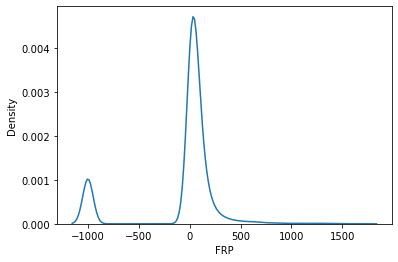

In [35]:
sns.kdeplot(df.FRP);

Most of the 🔥 places detected are relatively less intenseful. Let's now look at their geographical distribution. 

First, as usual, select a basemap from the ones we downloaded in the last post (look under XYZ Tiles in browser area). Ideally you would want to know the topography of the land in this case. So I went with `Google Terrain Hybrid`.

Now, unlike shapefiles, we can't simply drag a text file to the canvas. Instead, goto `Layer-> Add Layer -> Add Delimited Text Layer`. Fill it with the information as shown.

::: {#fig- }
![](images/add_txt.jpg)

Load text file
:::

:::{.callout-hint}
Don't forget to click **Add** before close in step `5` above.
:::

This would stack the file over our basemap. Now this is already good... but we are still not making use of the FRP information we have. Since it's numerical data, let's try to colorize the data based on this. We already know the higher the FRP, the intense the 🔥 is. As these are continuous values, let's bin them  into discrete classes based on the histrogram we saw above.

::: {#fig-styling layout-ncol=2}
![](images/fire_styling_I.jpg){#fig-a}

![](images/fire_styling_II.jpg){#fig-b}

Styling

:::

:::{.callout-tip}
The toolbar in fig. 3(b) can be accessed by clicking the 🟣 circle (`Symbol` section) in fig. 3(a). Change the values as you please.
:::

::: {#fig- }
![](images/fires.jpg)

🔥 activity across Northern Americas
:::

We clearly see that most of the activity is exclusively detected in the SE part of North America with most parts of Cuba, SE Mexico & NW of Florida.

Now that we know the intensity of the fires, we can also actually know from which satellite a given data point has originated. To do that, we need to label each data point with the corresponding value in the `Satellite` field as we have seen earlier.

::: {#fig- }
![](images/cuba_styling.jpg)

Styling for Labels
:::

::: {#fig- }
![](images/cuba.jpg)

Coordinates with Satellite names
:::

You may notice that the same coordinates have the same label repeated multiple times. That got me interested. So I digged in. I suspected that it could be because of duplicate entries of the coordinates.

In [54]:
df.shape, df.drop_duplicates().shape

((24485, 8), (24485, 8))

In [55]:
df.drop_duplicates(['Lat', 'Lon']).shape

(9752, 8)

Indeed it was. But only the coordinates are duplicated but not all the fields. 

In [45]:
df[['Lat', 'Lon']].value_counts().head()

Lat        Lon       
16.311804  -92.219566    156
19.440290  -89.355492    149
19.479744  -89.319229    131
19.153973  -90.197701    120
19.499657  -89.321320    116
dtype: int64

Let's take one example and see what's changing.

In [46]:
df.query('Lon==-92.219566 and Lat==16.311804')

,Lon,Lat,YearDay,Time,Satellite,Method,Ecosystem,FRP
2087,-92.219566,16.311804,2023065,1700,GOES-EAST,FDC,93,22.154
2393,-92.219566,16.311804,2023065,1721,GOES-EAST,FDC,93,33.626
2520,-92.219566,16.311804,2023065,1730,GOES-EAST,FDC,93,32.808
2738,-92.219566,16.311804,2023065,1741,GOES-EAST,FDC,93,31.866
4156,-92.219566,16.311804,2023065,1800,GOES-EAST,FDC,93,53.364
...,...,...,...,...,...,...,...,...
23682,-92.219566,16.311804,2023066,251,GOES-EAST,FDC,93,25.892
23704,-92.219566,16.311804,2023066,256,GOES-EAST,FDC,93,31.707
23759,-92.219566,16.311804,2023066,301,GOES-EAST,FDC,93,32.109
23786,-92.219566,16.311804,2023066,306,GOES-EAST,FDC,93,29.846


In [56]:
df.query('Lon==-92.219566 and Lat==16.311804').Satellite.unique()

array(['       GOES-EAST'], dtype=object)

Interesting! We now have different values for `FRP` over a single coordinate but at different times.

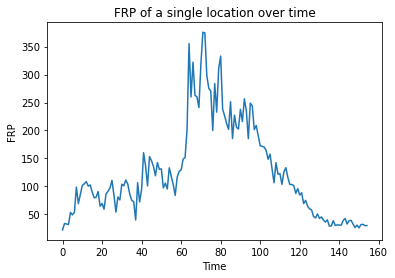

In [57]:
(df
 .query('Lon==-92.219566 and Lat==16.311804')    # take one location as an example
 .sort_values(['YearDay', 'Time'])               # sort it by time
 .query('FRP > 0')                               # filter out -ve values (incorrect data?)
 .reset_index(drop=True)                         # drop the index values
 .FRP
 .plot(title='FRP of a single location over time', xlabel='Time', ylabel='FRP'));

Nice! We now see how the `FRP` has evolved over time... it looks as if the 🔥 appears to have begun, spread, and intensified before eventually extinguishing or subsiding.

## filtering a text file

Coming back to our satellite names, we can filter only for the data coming from a single satellite by right clicking on the `hms_fire20230306` layer, selecting `filter` and later entering the query like so:

::: {#fig- }
![](images/csv_filter.jpg)

Filtering a CSV/TXT file
:::

- `1` - selects the field we want to filter
- `2` - gets a few sample values from that field
- `3` - double click on the field to enter it into the query box below. Alternatively you can type it as well.
- `4, 5` - double click/type
- `6` - clicking `Test` gives us how many rows that satisfy the condition. Hit `OK`
- `7` - ignore (don't click it)
- `8` - click `OK` to finalize the filtered data

If you now look at the later, we only see the datapoints from the satellite we filtered.

::: {#fig- }
![](images/filtered_entries.jpg)

Map with filtered entries
:::

## conclusion

Now we have seen how to load text files and filtering for our desired data. You can also load [Well Known Text](http://wiki.gis.com/wiki/index.php/Well-known_text) (WKT) and other text files in the same manner. Just make sure to select the appropriate radio button while loading them.

# Add WFS Connection

The Web Feature Service (WFS) protocol enables users to access and query feature data over the internet, without having to download and store the data locally. This can be particularly useful when working with large datasets or when collaborating with other users who may have different data sources or access privileges. WFS allows users to view and analyze feature data from multiple sources, combine data from different sources, and perform spatial and attribute queries on the data. This can help users to make more informed decisions and gain insights from the data that might not be apparent from a single dataset.

There are lot of publicly available WFS servers online (just google) including from universities, government organizations etc. [geoseer](https://www.geoseer.net) is one such service which provides links to those servers.

For our purposes, we shall take a look at one WFS server that offers water level information in Germany. So head over [here](https://www.geoseer.net/rl.php?ql=057545d9de309f76&p=1&q=wfs%20germany) and copy the [WFS URL](https://www.pegelonline.wsv.de/geoserver/gk/wfs).

As this is a data layer, as usual, we will add a basemap layer or two. In this case, I went with `CartoDB Positron`.

To add the WFS connection, goto `WFS/OGC API - Features` in the _browser_ area and click `New Connection`.

::: {#fig- }
![](images/wfs.jpg)

New WFS Connection
:::

Once you have done that above, you will notice a new connection appearing under that section. Clicking on it will reveal the layer that you can now simply drag & drop to the canvas.

We can right click on the added layer in the `Layers` section and select `Open Attribute Table` to reveal all its data in plaintext form. We notice that there's a field named `Value` that shows the depth of the water level. Now just like in our last use case, you can now use this field to bin its values to get the following map.

::: {#fig- }
![](images/water_levels.jpg)

Water Levels in Germany
:::

It shows that the levels are higher in North than in the South (most likely being it closer to the Sea) but it's troubling to see some major cities suffering with severe lack of ground water.

## Conclusion

Just like WFS, you can also add [WMS](https://en.wikipedia.org/wiki/Web_Map_Service)/[WCS](https://en.wikipedia.org/wiki/Web_Coverage_Service) services much the same way to carry out analysis without downloading data onto your disk.

# Final Words

In this post, we have seen how to use different types of data sources and possibly lighten our data resources on disk to perform our analysis and collaborate with others online when needed. We also performed query filtering to visualize only the data we need and how to do it in a meaningful way.

In the next post, we will make a bit more use of Python & QGIS scripting to write a complex processing pipeline.

Thanks for reading. 

Auf wiedersehen 👋